# V = 2, C = 10, Semi-Supervised Training on MNIST Data

Requires RainDancesVI package https://prasanthcakewalk.gitlab.io/raindancesvi/ (tested with version 0.1.0)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as klayers
from tensorflow.keras.datasets import mnist

import raindancesvi as rd6
from raindancesvi import inclass_utils

In [3]:
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'text.usetex': True, 'text.latex.preview': True})

def figname(string):
    fig_dir = 'figures/V2_C10_MNIST'
    fig_name_prefix = 'MNIST_'
    return f'{fig_dir}/{fig_name_prefix}{string}'

## Data and noisy label generation:

In [4]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

img_rows, img_cols = 28, 28
noisy_label_correct_frac = .6

w = [1/10]*10
N = 10**5

(input_train, target_train), (input_test, target_test) = mnist.load_data()
if keras.backend.image_data_format() == 'channels_first':
    input_train = input_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    input_test = input_test.reshape(input_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    input_train = input_train.reshape(input_train.shape[0], img_rows, img_cols, 1)
    input_test = input_test.reshape(input_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_digits = []
for digit in range(10):
    train_digits.append(input_train[target_train==digit])

target_train_noisy = np.where(rng.random(target_train.shape) < (10*noisy_label_correct_frac - 1)/9, 
                              target_train, rng.choice(10, target_train.shape))

target_train = keras.utils.to_categorical(target_train, 10)
target_train_noisy = keras.utils.to_categorical(target_train_noisy, 10)
target_test = keras.utils.to_categorical(target_test, 10)

# Paired images:
Ni = rng.multinomial(N, w)
train_paired_digits_x = []
train_paired_digits_y = []

for digit in range(10):
    tmp = rng.choice(len(train_digits[digit]), size=Ni[digit])
    train_paired_digits_x.append(train_digits[digit][tmp])
    
    tmp = rng.choice(len(train_digits[digit]), size=Ni[digit])
    train_paired_digits_y.append(train_digits[digit][tmp])

sample_x = np.concatenate(train_paired_digits_x)
sample_y = np.concatenate(train_paired_digits_y)

shuffle = rng.permutation(N)
sample_x = sample_x[shuffle]
sample_y = sample_y[shuffle]

print(len(input_train), len(input_test))

60000 10000


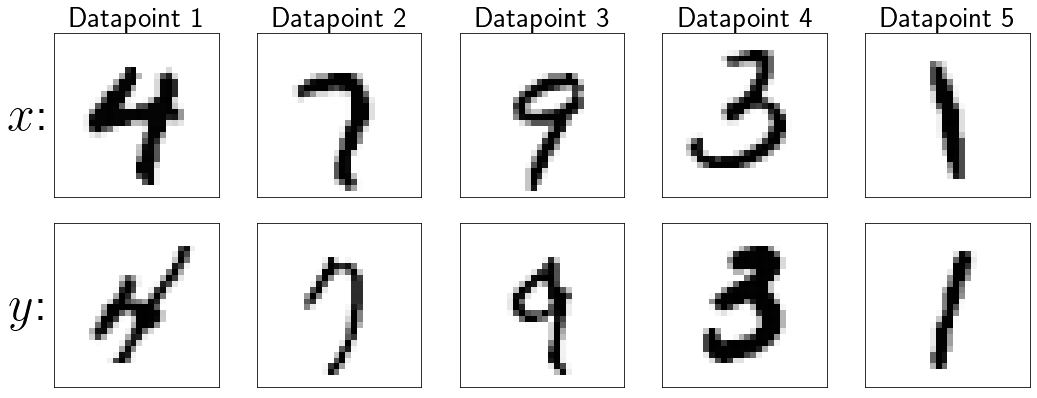

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for j in range(5):
    axes[0][j].imshow(sample_x[j].squeeze(), cmap='Greys', interpolation='none')
    axes[1][j].imshow(sample_y[j].squeeze(), cmap='Greys', interpolation='none')
    
    axes[0][j].set_title(f'Datapoint {j+1}')

for i in range(2):
    for j in range(5):
        #axes[i][j].axis('off')
        axes[i][j].axes.xaxis.set_visible(False)
        axes[i][j].axes.yaxis.set_visible(False)
        axes[i][j].set_aspect('equal')

axes[0][0].text(-5, 14, r'$x$:', ha='center', va='center', fontsize=50)
axes[1][0].text(-5, 14, r'$y$:', ha='center', va='center', fontsize=50)

fig.tight_layout()
plt.savefig(figname('data_samples.pdf'), bbox_inches='tight')

# Building two digit classification networks with shared intermediate layers:

In [6]:
tf.random.set_seed(1)
class_count = 10

input_x = keras.Input(shape=input_shape)
input_y = keras.Input(shape=input_shape)

layers = []
layers.append(klayers.Flatten(input_shape=input_shape))
layers.append(klayers.Dense(32, activation='relu'))
layers.append(klayers.Dense(32, activation='relu'))
layers.append(klayers.Dense(32, activation='relu'))
layers.append(klayers.Dense(class_count, activation='softmax'))

output_x = input_x
output_y = input_y
for layer in layers:
    output_x = layer(output_x)
    output_y = layer(output_y)

model_x = keras.Model(inputs=input_x, outputs=output_x)
model_y = keras.Model(inputs=input_y, outputs=output_y)

## Making an InClass Net out of the individual classifier networks:

In [7]:
inclass_model = rd6.InClassNet([model_x, model_y])
inclass_model.summary()

Model: "in_class_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           25120       flatten[0][0]         

In [8]:
untrained_model_x = keras.models.clone_model(model_x)
untrained_model_x.set_weights(model_x.get_weights())

## Pre-training using noisy labels:

In [9]:
model_x.compile(optimizer='adam', loss='categorical_crossentropy')

In [10]:
model_x.fit(input_train[:2000], target_train_noisy[:2000], batch_size=20, epochs=30)

Epoch 1/30
100/100 [==============================] - 0s 3ms/step - loss: 10.0952
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 2.6935
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 2.2697
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 2.1706
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 2.0861
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 2.0768
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 2.0195
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 1.9946
Epoch 9/30
100/100 [==============================] - 0s 1ms/step - loss: 1.9524
Epoch 10/30
100/100 [==============================] - 0s 2ms/step - loss: 1.9324
Epoch 11/30
100/100 [==============================] - 0s 2ms/step - loss: 1.9053
Epoch 12/30
100/100 [==============================] - 0s 2ms/step - loss: 1.8770
Epoch 13/30
100/100 [===

In [11]:
partially_trained_model_x = keras.models.clone_model(model_x)
partially_trained_model_x.set_weights(model_x.get_weights())

## Unsupervised training:

In [12]:
inclass_model.compile(optimizer='adam', loss=rd6.losses.neg_ctc_cost)

In [13]:
inclass_model.fit(x=[sample_x, sample_y], y='dummy', batch_size=100, epochs=20, validation_split=.1)

Epoch 1/20
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
900/900 [==============================] - 4s 4ms/step - loss: -1.4369 - val_loss: -1.6970
Epoch 2/20
900/900 [==============================] - 3s 4ms/step - loss: -1.8336 - val_loss: -1.8688
Epoch 3/20
900/900 [==============================] - 3s 4ms/step - loss: -1.9467 - val_loss: -1.9398
Epoch 4/20
900/900 [==============================] - 4s 5ms/step - loss: -1.9994 - val_loss: -1.9866
Epoch 5/20
900/900 [==============================] - 4s 4ms/step - loss: -2.0351 - val_loss: -2.0232
Epoch 6/20
900/900 [==============================] - 3s 4ms/step - loss: -2.0605 - val_loss: -2.0275
Epoch 7/20
900/900 [==============================] - 4s 4ms/step - loss: -2.0832 - val_loss: -2.0511
Epoch 8/20
900/900 [==============================] - 3s 4ms/step - loss: -2.0969 - val_loss: -2.0689
Epoch 9/20
900/900 [==============================] - 4s 4ms/step 

## Model evaluation:

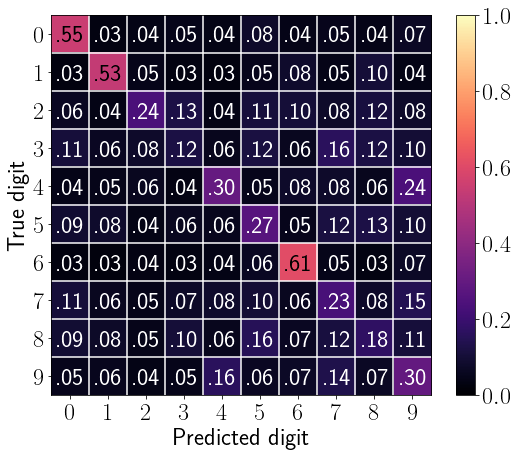

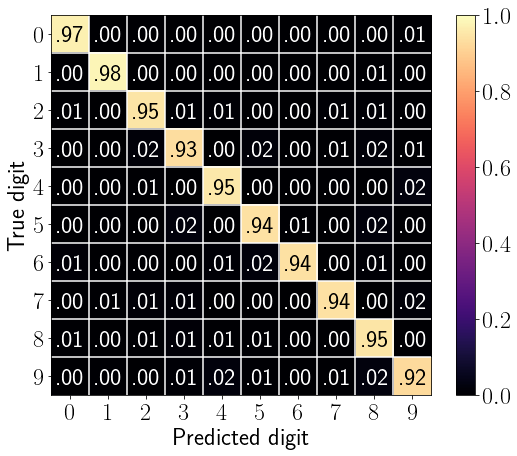

In [14]:
def plot_format(ax):
    ax.set_aspect('equal')
    ax.set_xlabel('Predicted digit')
    ax.set_ylabel('True digit')
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    for i in range(1, 10):
        ax.plot([-0.5, 9.5], [i-.5, i-.5], color='white', linewidth=1.5)
        ax.plot([i-.5, i-.5], [-0.5, 9.5], color='white', linewidth=1.5)

# tmp indices: true, pred
tmp = np.array([np.mean(partially_trained_model_x.predict(input_test[target_test[:,true] > .99]), axis=0) for true in range(10)])

fig, ax = plt.subplots(figsize=(9,7))
plt.gca().invert_yaxis()
_ = plt.imshow(tmp, cmap='magma', vmin=0, vmax=1)

for true in range(10):
    for pred in range(10):
        color = 'black' if tmp[true][pred] > 0.5 else 'white'
        ax.text(pred, true+.05, '{:.2f}'.format(round(tmp[true][pred], 2)).lstrip('0'), ha='center', va='center', color=color)

plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('pre_trained_confusion.pdf'), bbox_inches='tight')


tmp = np.array([np.mean(model_x.predict(input_test[target_test[:,true] > .99]), axis=0) for true in range(10)])
fig, ax = plt.subplots(figsize=(9,7))
plt.gca().invert_yaxis()
_ = plt.imshow(tmp, cmap='magma', vmin=0, vmax=1)

for true in range(10):
    for pred in range(10):
        color = 'black' if tmp[true][pred] > 0.5 else 'white'
        ax.text(pred, true+.05, '{:.2f}'.format(round(tmp[true][pred], 2)).lstrip('0'), ha='center', va='center', color=color)

plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('trained_confusion.pdf'), bbox_inches='tight')